In [50]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define portfolio tickers and date range
tickers = ['XLK']  # Example portfolio
end_date = datetime.now()
start_date = end_date - timedelta(days=365)  # One year ago

# Fetch data for each ticker
data = {}
for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = stock_data['Adj Close']  # Adjusted Close prices

# Convert to a DataFrame
df = pd.DataFrame(data)
#print("Data Collection Completed. Sample Data:")
#print(df.head()
df


[*********************100%***********************]  1 of 1 completed


,XLK
Date,
2023-11-08,174.473892
2023-11-09,173.659943
2023-11-10,178.196259
2023-11-13,177.153992
2023-11-14,180.697647
...,...
2024-11-01,223.910004
2024-11-04,223.740005
2024-11-05,226.889999


In [51]:
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values
df.fillna(method='ffill', inplace=True)  # Forward fill for NaN values
df.dropna(inplace=True)  # Drop remaining NaNs if any

# Confirm no missing values
print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
XLK    0
dtype: int64
Missing values after cleaning:
XLK    0
dtype: int64


/var/folders/jh/5qgf89253j945pw6bjvtshgr0000gn/T/ipykernel_66044/1378425683.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill for NaN values


In [52]:
daily_returns = df.pct_change().dropna()

# Display basic statistics for daily returns
print("Daily Returns Statistics:")
print(daily_returns.describe())

Daily Returns Statistics:
              XLK
count  251.000000
mean     0.001322
std      0.013752
min     -0.045931
25%     -0.004691
50%      0.002268
75%      0.008772
max      0.042351


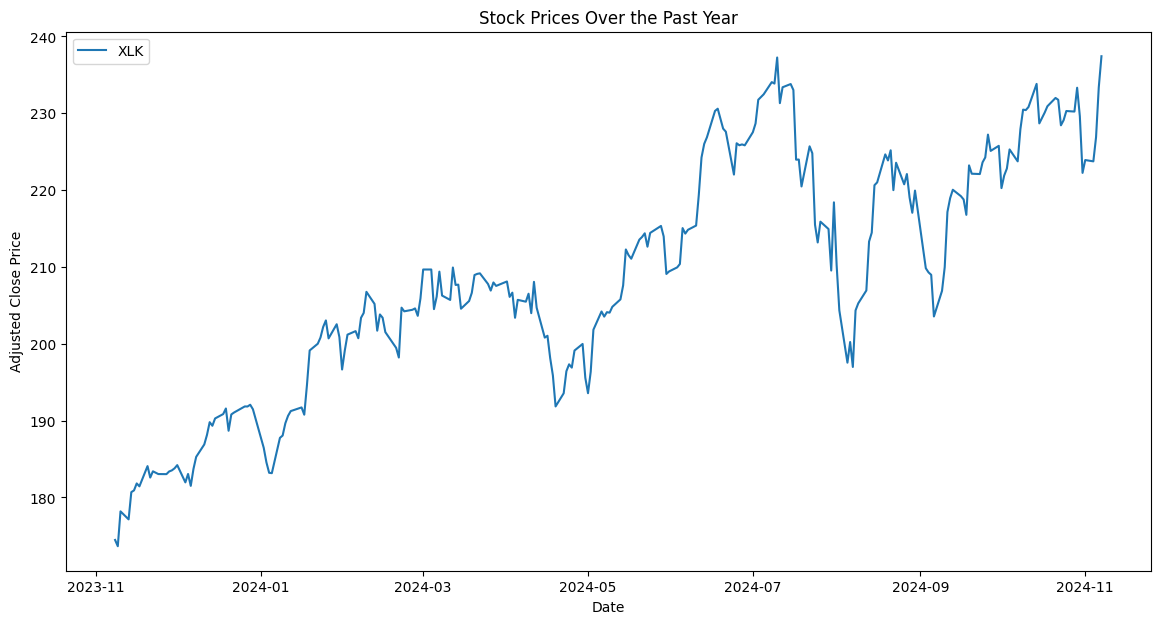

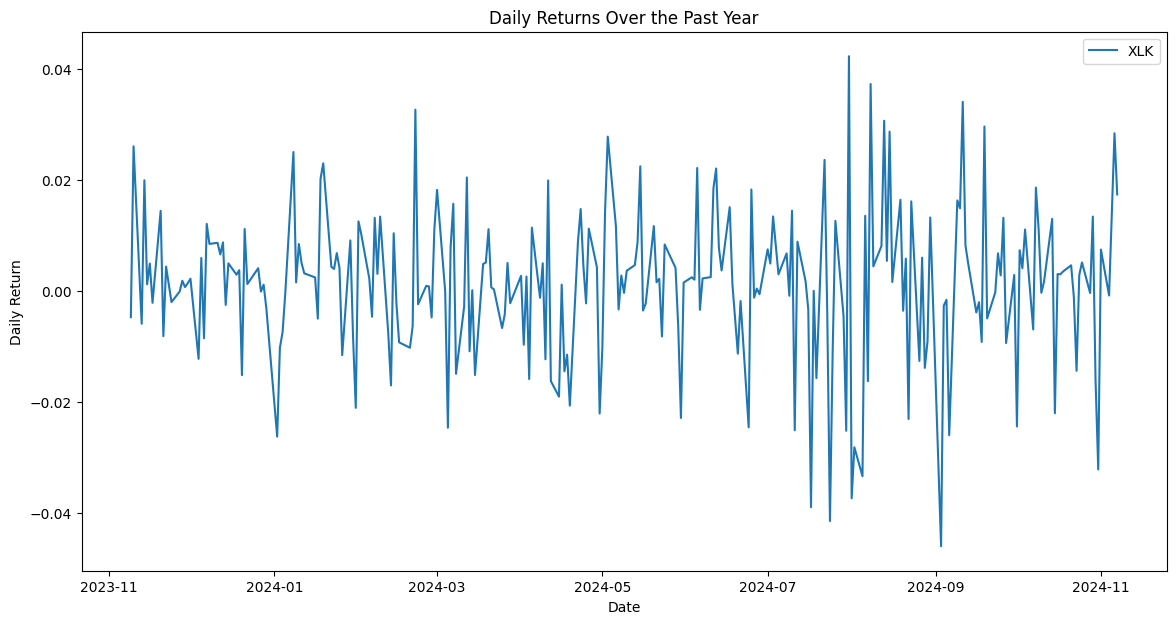

In [53]:
import matplotlib.pyplot as plt

# Plot Adjusted Close prices
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(df[ticker], label=ticker)
plt.title("Stock Prices Over the Past Year")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Plot Daily Returns
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(daily_returns[ticker], label=ticker)
plt.title("Daily Returns Over the Past Year")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

In [54]:
risk_free_rate = 0  # Set to 0 for now, but you can change this

# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Number of trading days in a year (used for annualization)
trading_days = 252

# Calculate Sharpe Ratio for each stock with annualization
sharpe_ratios = {}
for ticker in tickers:
    avg_daily_return = daily_returns[ticker].mean()
    std_dev_return = daily_returns[ticker].std()
    
    # Annualized Sharpe Ratio calculation
    sharpe_ratio = ((avg_daily_return - risk_free_rate) / std_dev_return) * (trading_days ** 0.5)
    sharpe_ratios[ticker] = sharpe_ratio

# Display Sharpe Ratios
print("Annualized Sharpe Ratios for each stock:")
for ticker, ratio in sharpe_ratios.items():
    print(f"{ticker}: {ratio:.3f}")

Annualized Sharpe Ratios for each stock:
XLK: 1.527


In [55]:
risk_assessment = {}
threshold = 1  # Define your threshold for "risky"

for ticker, ratio in sharpe_ratios.items():
    if ratio < threshold:
        risk_assessment[ticker] = "Risky - Consider Selling"
    else:
        risk_assessment[ticker] = "Safe - Consider Keeping"

# Display risk assessment
print("\nRisk Assessment for each stock:")
for ticker, assessment in risk_assessment.items():
    print(f"{ticker}: {assessment}")


Risk Assessment for each stock:
XLK: Safe - Consider Keeping


In [60]:




# Fetch data for each ticker
data = {}
for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = stock_data

# Create a DataFrame of Adjusted Close prices
adj_close_df = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})

# Calculate daily returns
daily_returns = adj_close_df.pct_change().dropna()

# Additional Metrics Calculation
metrics = {}

for ticker in tickers:
    stock_data = data[ticker]
    
    # Calculate Beta
    # Compare with S&P 500 (using ^GSPC as an index)
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
    sp500_returns = sp500.pct_change().dropna()
    beta = daily_returns[ticker].cov(sp500_returns) / sp500_returns.var()
    
    # Calculate Volatility (standard deviation of returns)
    volatility = daily_returns[ticker].std()
    
    # Moving Averages
    stock_data['50_day_MA'] = stock_data['Adj Close'].rolling(window=50).mean()
    stock_data['200_day_MA'] = stock_data['Adj Close'].rolling(window=200).mean()
    
    # Maximum Drawdown
    cumulative_return = (1 + daily_returns[ticker]).cumprod()
    peak = cumulative_return.cummax()
    drawdown = (cumulative_return - peak) / peak
    max_drawdown = drawdown.min()

    # Sortino Ratio (only penalizes for negative returns)
    negative_volatility = daily_returns[ticker][daily_returns[ticker] < 0].std()
    sortino_ratio = daily_returns[ticker].mean() / negative_volatility

    # Add metrics to dictionary
    metrics[ticker] = {
        "Beta": beta,
        "Volatility": volatility,
        "Max Drawdown": max_drawdown,
        "Sortino Ratio": sortino_ratio,
        "50-day MA": stock_data['50_day_MA'].iloc[-1],
        "200-day MA": stock_data['200_day_MA'].iloc[-1],
    }

# Convert metrics to DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics).T
print("Enhanced Stock Metrics:")
print(metrics_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Enhanced Stock Metrics:
         Beta  Volatility  Max Drawdown  Sortino Ratio   50-day MA  200-day MA
XLK  1.579753    0.013752     -0.169724       0.128237  223.770955  214.301055


In [62]:
# Assign risk level based on combined metrics
def calculate_risk_level(beta, volatility, max_drawdown, sortino_ratio, ma_short, ma_long):
    # Initialize score
    score = 0

    # Beta score
    if beta <= 0.5:
        score += 1
    elif 0.5 < beta <= 1.0:
        score += 2
    elif 1.0 < beta <= 1.5:
        score += 3
    else:
        score += 4

    # Volatility score
    if volatility < 0.02:
        score += 1
    elif 0.02 <= volatility < 0.04:
        score += 2
    elif 0.04 <= volatility < 0.06:
        score += 3
    else:
        score += 4

    # Max Drawdown score
    if max_drawdown > -0.10:
        score += 1
    elif -0.10 >= max_drawdown > -0.20:
        score += 2
    elif -0.20 >= max_drawdown > -0.30:
        score += 3
    else:
        score += 4

    # Sortino Ratio score
    if sortino_ratio >= 2.0:
        score += 1
    elif 1.5 <= sortino_ratio < 2.0:
        score += 2
    elif 1.0 <= sortino_ratio < 1.5:
        score += 3
    else:
        score += 4

    # Moving Averages score
    if ma_short > ma_long:
        score += 1  # Positive trend
    else:
        score += 3  # Negative trend

    # Map total score to risk level and recommendation
    if score <= 5:
        return "Very Low Risk - Definitely Keep"
    elif score <= 8:
        return "Low Risk - Strongly Consider Keeping"
    elif score <= 11:
        return "Moderately Low Risk - Consider Keeping"
    elif score <= 14:
        return "Low-Medium Risk - Probably Keep"
    elif score == 15:
        return "Medium Risk - Maybe Keep"
    elif score <= 17:
        return "Medium-High Risk - Neutral, Review Carefully"
    elif score <= 19:
        return "High-Medium Risk - Probably Sell"
    elif score <= 22:
        return "Moderately High Risk - Consider Selling"
    elif score <= 24:
        return "High Risk - Strongly Consider Selling"
    else:
        return "Very High Risk - Definitely Sell"

# Apply the function to your enhanced metrics
risk_assessment = {}

for ticker in tickers:
    metrics = enhanced_metrics.get(ticker)
    if metrics:
        # Calculate the risk level
        risk_level = calculate_risk_level(
            beta=metrics["Beta"],
            volatility=metrics["Volatility"],
            max_drawdown=metrics["Max Drawdown"],
            sortino_ratio=metrics["Sortino Ratio"],
            ma_short=metrics["50-day MA"],
            ma_long=metrics["200-day MA"]
        )
        risk_assessment[ticker] = risk_level

# Display risk assessment
print("\nRisk Assessment for each stock:")
for ticker, assessment in risk_assessment.items():
    print(f"{ticker}: {assessment}")


Risk Assessment for each stock:
